In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [67]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0    
nfreq = 1

In [68]:
# Sx  = 20    
# Sy = 20
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

tpml = 0.4

boundary_layers = [
    mp.PML(tpml, direction=mp.Y),
    mp.PML(tpml, direction=mp.X)
]


tag_bot   = 0.5
tsio2     = 4
tag_side  = 4
design_region_height = 0.5
monitor_position     = 0.5 * 2
monitor_blank        = 0.5 * 0.1

width_ag       = 0.2
width_sio2     = 2
width_bot_ag   = round(width_ag + width_sio2 + width_ag, 2)
design_region_width  = round(width_bot_ag, 3)

Sx = 7.2+2*tpml
Sy = 6.85
cell_size   = mp.Vector3(Sx, Sy)

y_bottom = -Sy/2 + tpml
center_y_ag        = y_bottom + tag_bot/2
center_y_sio2      = y_bottom + tag_bot + tsio2/2
center_y_design    = y_bottom + tag_bot + tsio2 + design_region_height/2
center_y_monitor_position   = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position    = y_bottom + tag_bot + 5/fcen  # 예시
center_Ag_x_offset = design_region_width/2 - width_ag/2

Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1

geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side Ag layers
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_offset, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3( center_Ag_x_offset, center_y_sio2, 0)
    ),
]

In [69]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, 1.325, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [70]:
design_layer = np.loadtxt("SingleDipole_sum.txt")
design_variables.update_weights(design_layer)

In [71]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]

k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        k_point=k0
    )
    for src in sources
]

In [72]:
inner_x = Sx - 2*tpml
inner_y = Sy - 2*tpml

# 모니터가 놓일 중심 좌표
y_off = 0.5 * inner_y     # y축 상·하단
x_off = 0.5 * inner_x     # x축 좌·우단

nearfield_box = sims[0].add_near2far(
    fcen, 0, 1,
    # y축 상단
    mp.Near2FarRegion(
        center=mp.Vector3(0, +y_off),
        size=mp.Vector3(inner_x, 0)
    ),
    # y축 하단
    mp.Near2FarRegion(
        center=mp.Vector3(0, -y_off),
        size=mp.Vector3(inner_x, 0),
        weight=-1
    ),
    # x축 우측
    mp.Near2FarRegion(
        center=mp.Vector3(+x_off, 0),
        size=mp.Vector3(0, inner_y)
    ),
    # x축 좌측
    mp.Near2FarRegion(
        center=mp.Vector3(-x_off, 0),
        size=mp.Vector3(0, inner_y),
        weight=-1
    )
)

     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

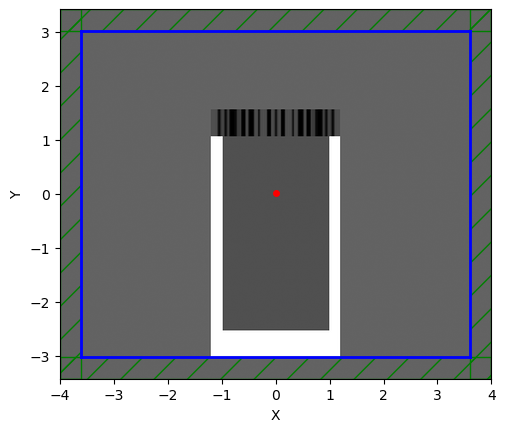

In [73]:
sims[0].plot2D()

In [74]:
# sims[0].run(until_after_sources=mp.stop_when_fields_decayed(
#             10/df, mp.Ez, sources[0].center, 1e-3
#         ))
# sims[0].run(until_after_sources=mp.stop_when_dft_decayed())
sims[0].run(until=300)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000454903 s
Working in 2D dimensions.
Computational cell is 8 x 6.86 x 0 with resolution 50
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.198443 s
lorentzian susceptibility: frequency=16.365, gamma=1.

     block, center = (0,-2.775,0)
          size (2.4,0.5,0)


          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

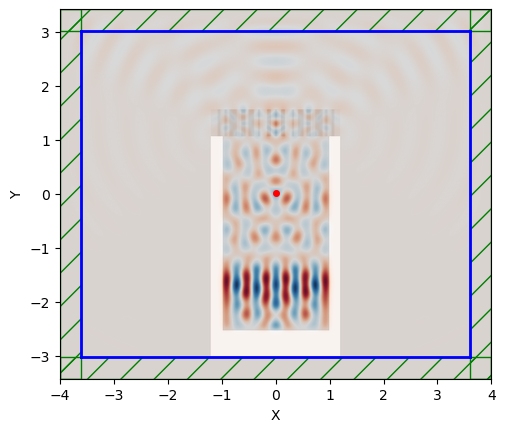

In [75]:
sims[0].plot2D(fields=mp.Ez)

In [76]:
r = 1000/fcen

# resolution of far fields (points/μm)
res_ff = 1

far_flux_box = (nearfield_box.flux(mp.Y,
                                   mp.Volume(center=mp.Vector3(y=r),
                                             size=mp.Vector3(2*r)),
                                   res_ff)[0] -
                nearfield_box.flux(mp.Y,
                                   mp.Volume(center=mp.Vector3(y=-r),
                                             size=mp.Vector3(2*r)),
                                   res_ff)[0] +
                nearfield_box.flux(mp.X,
                                   mp.Volume(center=mp.Vector3(r),
                                             size=mp.Vector3(y=2*r)),
                                   res_ff)[0] -
                nearfield_box.flux(mp.X,
                                   mp.Volume(center=mp.Vector3(-r),
                                             size=mp.Vector3(y=2*r)),
                                   res_ff)[0])

In [77]:
npts = 100  # number of points in [0,2*pi) range of angles
angles = 2*math.pi/npts*np.arange(npts)

E = np.zeros((npts,3),dtype=np.complex128)
H = np.zeros((npts,3),dtype=np.complex128)
for n in range(npts):
    ff = sims[0].get_farfield(nearfield_box,
                          mp.Vector3(r*math.cos(angles[n]),
                                     r*math.sin(angles[n])))
    E[n,:] = [ff[j] for j in range(3)]
    H[n,:] = [ff[j+3] for j in range(3)]

Px = np.real(np.conj(E[:, 1]) * H[:, 2] - np.conj(E[:, 2]) * H[:, 1])
Py = np.real(np.conj(E[:, 2]) * H[:, 0] - np.conj(E[:, 0]) * H[:, 2])
Pr = np.sqrt(np.square(Px) + np.square(Py))

# integrate the radial flux over the circle circumference
far_flux_circle = np.sum(Pr)*2*np.pi*r/len(Pr)

print("flux:,  {:.6f}, {:.6f}".format(far_flux_box,far_flux_circle))

flux:,  0.505986, 0.505489


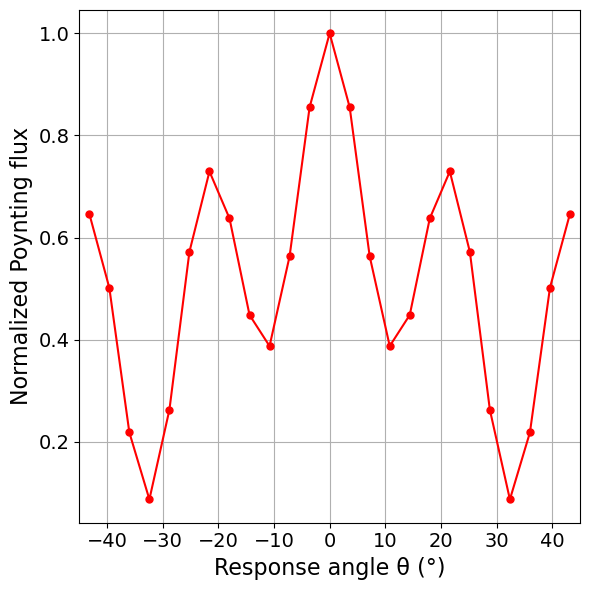

In [78]:
angles_deg = np.degrees(angles) - 90

angle_min = -45  
angle_max =  45

mask      = (angles_deg >= angle_min) & (angles_deg <= angle_max)
angles_sel = angles_deg[mask]
Pr_sel     = Pr[mask]

Pr_sel /= np.max(Pr_sel)

plt.figure(figsize=(6,6))
plt.plot(angles_sel, Pr_sel, 'ro-', markersize=5)
plt.xlim(angle_min, angle_max)
plt.xlabel("Response angle θ (°)", fontsize=16)
plt.ylabel("Normalized Poynting flux", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
Pr_sel

array([0.64669835, 0.50160018, 0.21824349, 0.08710339, 0.26258437,
       0.57216865, 0.72941682, 0.63747624, 0.44835735, 0.38741341,
       0.56314403, 0.85527027, 1.        , 0.85527027, 0.56314403,
       0.38741341, 0.44835735, 0.63747624, 0.72941682, 0.57216865,
       0.26258437, 0.08710339, 0.21824349, 0.50160018, 0.64669835])

In [80]:
angles_sel

array([-4.32000000e+01, -3.96000000e+01, -3.60000000e+01, -3.24000000e+01,
       -2.88000000e+01, -2.52000000e+01, -2.16000000e+01, -1.80000000e+01,
       -1.44000000e+01, -1.08000000e+01, -7.20000000e+00, -3.60000000e+00,
        1.42108547e-14,  3.60000000e+00,  7.20000000e+00,  1.08000000e+01,
        1.44000000e+01,  1.80000000e+01,  2.16000000e+01,  2.52000000e+01,
        2.88000000e+01,  3.24000000e+01,  3.60000000e+01,  3.96000000e+01,
        4.32000000e+01])